# Neural Network Binning

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tomo_challenge import load_data, load_redshift
from tomo_challenge.jax_metrics import ell_binning, compute_scores

Found classifier Random
Found classifier ZotBin
Found classifier RandomForest
Found classifier IBandOnly


In [3]:
import jax.random
import jax.numpy as jnp

In [4]:
from flax import nn, optim, serialization

Initialize fast metric calculations:

In [5]:
from zotbin.binned import *

In [6]:
init_data = load_binned('binned_40.npz')

Load the challenge data:

In [7]:
bands='riz'
include_colors=False
include_errors=False

In [8]:
train_file='/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5'
train_data = load_data(train_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
train_z = load_redshift(train_file)
print(f'Loaded {len(train_data)} training rows.')

Loaded 5410171 training rows.


/home/dkirkby/DESC/tomo/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


In [9]:
validation_file='/media/data2/tomo_challenge_data/ugrizy_buzzard/validation.hdf5'
valid_data = load_data(validation_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
valid_z = load_redshift(validation_file)
print(f'Loaded {len(valid_data)} validation rows.')

Loaded 10817982 validation rows.


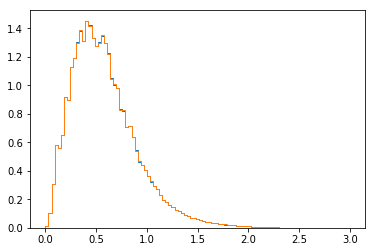

In [41]:
plt.hist(train_z, bins=np.linspace(0, 3, 100), density=True, label='TRAIN', histtype='step')
plt.hist(valid_z, bins=np.linspace(0, 3, 100), density=True, label='VALID', histtype='step');

Preprocess the training data:

In [47]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [55]:
def prepare_features(data, colors=True, pca=True, preprocessor=None):
    features = data
    if colors:
        # Add colors to the raw magnitudes.
        features = np.concatenate((features, np.diff(data, axis=1)), axis=1)
    if pca:
        print('Initializing PCA')
        pca = PCA(n_components=data.shape[1]).fit(features)
        print('Adding PCA')
        principal = pca.transform(features)
        features = np.concatenate((features, principal), axis=1)
    if preprocessor is None:
        print('Initializing preprocessor')
        preprocessor = RobustScaler()
        preprocessor.fit(features)
    return preprocessor.transform(features), preprocessor

In [56]:
train_features, preproc = prepare_features(train_data)

Initializing PCA
Adding PCA
Initializing preprocessor


In [57]:
valid_features, _ = prepare_features(valid_data, preprocessor=preproc)

Initializing PCA
Adding PCA


In [59]:
train_features.shape, valid_features.shape

((5410171, 8), (10817982, 8))

Load classification labels:

In [60]:
label2 = np.load('buzzard_labels2.npy')
label4 = np.load('buzzard_labels4.npy')
label8 = np.load('buzzard_labels8.npy')

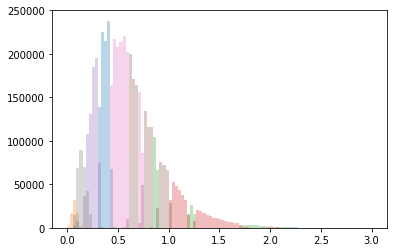

In [61]:
for i in range(8):
    plt.hist(train_z[label8 == i], bins=np.linspace(0, 3, 100), alpha=0.3)

Build a dense classifier network:

In [72]:
class Classifier(nn.Module):
    def apply(self, x):
        x = nn.Dense(x, features=100, name='L1')
        x = nn.relu(x)
        x = nn.Dense(x, features=100, name='L2')
        x = nn.relu(x)
        x = nn.Dense(x, features=100, name='L3')
        x = nn.relu(x)
        x = nn.Dense(x, features=8, name='Out')
        x = nn.log_softmax(x)
        return x

In [73]:
@jax.vmap
def cross_entropy_loss(logits, label):
    return -logits[label]

In [74]:
@jax.jit
def train_step(optimizer, batch):
    def loss_fn(model):
        logits = model(batch['features'])
        loss = jnp.mean(cross_entropy_loss(logits, batch['labels']))
        return loss
    grad = jax.grad(loss_fn)(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return optimizer

In [75]:
@jax.jit
def eval_step(model, eval_ds):
    logits = model(eval_ds['features'])
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == eval_ds['labels'])
    loss = jnp.mean(cross_entropy_loss(logits, eval_ds['labels']))
    return {'loss': loss,  'accuracy': accuracy}

In [77]:
def train(features, labels, lr=0.001, beta=0.9, batchsize=10000, nepoch=100, seed=123):
    
    features = jnp.asarray(features)
    labels = jnp.asarray(labels, jnp.int32)
    ndata = len(features)
    nbatch = ndata // batchsize
    gen = np.random.RandomState(seed)
    
    _, initial_params = Classifier.init(jax.random.PRNGKey(0), features[:batchsize])
    model = nn.Model(Classifier, initial_params)
    print(jax.tree_map(jnp.shape, model.params))
    #optimizer = optim.Momentum(learning_rate=lr, beta=beta).create(model)
    optimizer = optim.Adam(learning_rate=lr, beta1=beta).create(model)
    
    for epoch in range(nepoch):
        batch = gen.choice(ndata, nbatch * batchsize, replace=False).reshape(nbatch, batchsize)
        for i in range(nbatch):
            optimizer = train_step(optimizer, {'features': features[batch[i]], 'labels': labels[batch[i]]})
        train_eval = eval_step(optimizer.target, {'features': features, 'labels': labels})
        print(f"epoch {epoch+1}/{nepoch}: train loss={train_eval['loss']:.6f} accuracy={train_eval['accuracy']:.6f}")
    # Calculate final scores on the validation data.
    nvalid = 10000
    logits = optimizer.target(valid_features[:nvalid])
    valid_labels = jnp.argmax(logits, axis=-1)
    #scores = compute_scores(valid_labels, valid_z[:nvalid], metrics=['SNR_3x2', 'FOM_3x2', 'FOM_DETF_3x2'])
    #print(scores)

In [78]:
train(train_features, label8, lr=0.001, nepoch=25)

{'L1': {'bias': (100,), 'kernel': (8, 100)}, 'L2': {'bias': (100,), 'kernel': (100, 100)}, 'L3': {'bias': (100,), 'kernel': (100, 100)}, 'Out': {'bias': (8,), 'kernel': (100, 8)}}
epoch 1/25: train loss=0.922596 accuracy=0.610693
epoch 2/25: train loss=0.905724 accuracy=0.614748
epoch 3/25: train loss=0.899725 accuracy=0.616237
epoch 4/25: train loss=0.897405 accuracy=0.617127
epoch 5/25: train loss=0.894007 accuracy=0.617421
epoch 6/25: train loss=0.892651 accuracy=0.617482
epoch 7/25: train loss=0.892674 accuracy=0.617876
epoch 8/25: train loss=0.888223 accuracy=0.619265
epoch 9/25: train loss=0.887999 accuracy=0.619324
epoch 10/25: train loss=0.887477 accuracy=0.619587
epoch 11/25: train loss=0.887147 accuracy=0.620050
epoch 12/25: train loss=0.887621 accuracy=0.618943
epoch 13/25: train loss=0.886701 accuracy=0.619497
epoch 14/25: train loss=0.885256 accuracy=0.620413
epoch 15/25: train loss=0.885207 accuracy=0.620071
epoch 16/25: train loss=0.884379 accuracy=0.620237
epoch 17/25: 

In [69]:
train(train_features, label8, lr=0.01, nepoch=25)

{'L1': {'bias': (100,), 'kernel': (8, 100)}, 'L2': {'bias': (100,), 'kernel': (100, 100)}, 'L3': {'bias': (8,), 'kernel': (100, 8)}}
epoch 1/25: train loss=0.903163 accuracy=0.614542
epoch 2/25: train loss=0.898913 accuracy=0.615908
epoch 3/25: train loss=0.894257 accuracy=0.615906
epoch 4/25: train loss=0.892889 accuracy=0.617070
epoch 5/25: train loss=0.888801 accuracy=0.619136
epoch 6/25: train loss=0.889233 accuracy=0.619295
epoch 7/25: train loss=0.887600 accuracy=0.619112
epoch 8/25: train loss=0.886174 accuracy=0.619626
epoch 9/25: train loss=0.885754 accuracy=0.619567
epoch 10/25: train loss=0.885733 accuracy=0.619554
epoch 11/25: train loss=0.888255 accuracy=0.619026
epoch 12/25: train loss=0.885853 accuracy=0.619142
epoch 13/25: train loss=0.886501 accuracy=0.619118
epoch 14/25: train loss=0.885347 accuracy=0.618829
epoch 15/25: train loss=0.885300 accuracy=0.618889
epoch 16/25: train loss=0.884241 accuracy=0.619364
epoch 17/25: train loss=0.885148 accuracy=0.619399
epoch 18/

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


{'SNR_3x2': 1528.724853515625, 'FOM_3x2': 5182.98291015625, 'FOM_DETF_3x2': 77.8504638671875}


In [46]:
train(features2, label8, lr=0.001, nepoch=25)

{'L1': {'bias': (100,), 'kernel': (5, 100)}, 'L2': {'bias': (100,), 'kernel': (100, 100)}, 'L3': {'bias': (8,), 'kernel': (100, 8)}}
epoch 1/25: train loss=0.961995 accuracy=0.599905
epoch 2/25: train loss=0.930175 accuracy=0.609277
epoch 3/25: train loss=0.916610 accuracy=0.613058
epoch 4/25: train loss=0.909615 accuracy=0.614050
epoch 5/25: train loss=0.906061 accuracy=0.614354
epoch 6/25: train loss=0.901649 accuracy=0.616335
epoch 7/25: train loss=0.899719 accuracy=0.616357
epoch 8/25: train loss=0.897166 accuracy=0.617310
epoch 9/25: train loss=0.895917 accuracy=0.617580
epoch 10/25: train loss=0.895414 accuracy=0.617646
epoch 11/25: train loss=0.893363 accuracy=0.618402
epoch 12/25: train loss=0.895605 accuracy=0.616679
epoch 13/25: train loss=0.893294 accuracy=0.617549
epoch 14/25: train loss=0.892446 accuracy=0.617936
epoch 15/25: train loss=0.891476 accuracy=0.618080
epoch 16/25: train loss=0.890085 accuracy=0.618846
epoch 17/25: train loss=0.889505 accuracy=0.619507
epoch 18/

In [85]:
train(features2, label8)

{'L1': {'bias': (100,), 'kernel': (5, 100)}, 'L2': {'bias': (100,), 'kernel': (100, 100)}, 'L3': {'bias': (8,), 'kernel': (100, 8)}}
epoch 1/100: train loss=1.344506 accuracy=0.502946
epoch 2/100: train loss=1.211980 accuracy=0.507931
epoch 3/100: train loss=1.151192 accuracy=0.518618
epoch 4/100: train loss=1.114971 accuracy=0.534782
epoch 5/100: train loss=1.091149 accuracy=0.545790
epoch 6/100: train loss=1.073817 accuracy=0.551027
epoch 7/100: train loss=1.060467 accuracy=0.555895
epoch 8/100: train loss=1.049600 accuracy=0.560309
epoch 9/100: train loss=1.040583 accuracy=0.564981
epoch 10/100: train loss=1.032976 accuracy=0.568808
epoch 11/100: train loss=1.026528 accuracy=0.573087
epoch 12/100: train loss=1.020986 accuracy=0.576905
epoch 13/100: train loss=1.015984 accuracy=0.580217
epoch 14/100: train loss=1.011693 accuracy=0.582451
epoch 15/100: train loss=1.007881 accuracy=0.584231
epoch 16/100: train loss=1.004379 accuracy=0.586144
epoch 17/100: train loss=1.001204 accuracy=0

In [90]:
train(features2, label8)

{'L1': {'bias': (100,), 'kernel': (5, 100)}, 'L2': {'bias': (100,), 'kernel': (100, 100)}, 'L3': {'bias': (8,), 'kernel': (100, 8)}}
epoch 1/100: train loss=0.961947 accuracy=0.599999
epoch 2/100: train loss=0.930119 accuracy=0.609243
epoch 3/100: train loss=0.916653 accuracy=0.613068
epoch 4/100: train loss=0.909556 accuracy=0.614079
epoch 5/100: train loss=0.905720 accuracy=0.614434
epoch 6/100: train loss=0.901549 accuracy=0.616372
epoch 7/100: train loss=0.899326 accuracy=0.616597
epoch 8/100: train loss=0.896991 accuracy=0.617336
epoch 9/100: train loss=0.895742 accuracy=0.617588
epoch 10/100: train loss=0.895193 accuracy=0.617736
epoch 11/100: train loss=0.893125 accuracy=0.618440
epoch 12/100: train loss=0.895076 accuracy=0.617022
epoch 13/100: train loss=0.893161 accuracy=0.617841
epoch 14/100: train loss=0.891973 accuracy=0.618333
epoch 15/100: train loss=0.891791 accuracy=0.617958
epoch 16/100: train loss=0.889731 accuracy=0.619012
epoch 17/100: train loss=0.889311 accuracy=0

## Sandbox

In [37]:
ndata = 10000
features = jnp.array(features[:ndata])
labels = jnp.array(train_z[:ndata])

Define a network:

In [34]:
nbins = 4

In [24]:
class NN(nn.Module):
    def apply(self, x, nbins):
        x = nn.Dense(x, 100, name='L1')
        x = nn.relu(x)
        x = nn.Dense(x, 100, name='L2')
        x = nn.relu(x)
        x = nn.Dense(x, nbins, name='L3')
        return nn.softmax(x)

In [25]:
module = NN.partial(nbins=4)

In [26]:
_, nn_init = module.init(jax.random.PRNGKey(0), features)

In [27]:
jax.tree_map(jnp.shape, nn_init)

{'L1': {'bias': (100,), 'kernel': (4, 100)},
 'L2': {'bias': (100,), 'kernel': (100, 100)},
 'L3': {'bias': (4,), 'kernel': (100, 4)}}

In [28]:
model = nn.Model(module, nn_init)

In [29]:
jax.tree_map(jnp.shape, model.params)

{'L1': {'bias': (100,), 'kernel': (4, 100)},
 'L2': {'bias': (100,), 'kernel': (100, 100)},
 'L3': {'bias': (4,), 'kernel': (100, 4)}}

In [30]:
model(features[0])

DeviceArray([0.20889738, 0.25362805, 0.26156127, 0.27591333], dtype=float32)

In [61]:
optimizer = optim.Adam(learning_rate=0.001).create(model)

In [68]:
def train_step(optimizer, batch):
    
    def loss_fn(model):
        out = model(batch['features'])
        idx = jnp.argmax(out, axis=-1)
        print(idx)
        scores = get_binned_scores(idx, batch['z'], *init_data)
        print(scores)
        return scores['FOM_DETF_3x2']
    
    loss, g = jax.value_and_grad(loss_fn)(optimizer.target)
    optimizer = optimizer.apply_gradient(g)
    return optimizer, loss

In [69]:
nbatch = 10
gen = np.random.RandomState(123)

In [70]:
def get_batch():
    idx = gen.choice(ndata, nbatch)
    return {'features': features[idx], 'z': labels[idx]}

In [71]:
def train(opt, niter=10):
    
    losses = []
    for i in range(niter):
        opt, loss = train_step(opt, get_batch())
        print(loss)
        
train(optimizer)

[3 3 3 3 3 3 2 0 3 1]
{'SNR_3x2': DeviceArray(1319.0688, dtype=float32), 'FOM_3x2': DeviceArray(2835.5964, dtype=float32), 'FOM_DETF_3x2': DeviceArray(29.425533, dtype=float32)}
29.425533
[0 3 3 3 3 0 3 3 3 3]
{'SNR_3x2': DeviceArray(nan, dtype=float32), 'FOM_3x2': DeviceArray(nan, dtype=float32), 'FOM_DETF_3x2': DeviceArray(nan, dtype=float32)}
nan
[3 2 3 3 3 3 3 3 3 3]
{'SNR_3x2': DeviceArray(nan, dtype=float32), 'FOM_3x2': DeviceArray(nan, dtype=float32), 'FOM_DETF_3x2': DeviceArray(nan, dtype=float32)}
nan
[3 2 3 3 3 3 3 3 3 2]
{'SNR_3x2': DeviceArray(nan, dtype=float32), 'FOM_3x2': DeviceArray(nan, dtype=float32), 'FOM_DETF_3x2': DeviceArray(nan, dtype=float32)}
nan
[3 2 2 2 2 3 3 3 3 3]
{'SNR_3x2': DeviceArray(nan, dtype=float32), 'FOM_3x2': DeviceArray(nan, dtype=float32), 'FOM_DETF_3x2': DeviceArray(nan, dtype=float32)}
nan
[3 3 3 3 2 2 3 3 3 2]
{'SNR_3x2': DeviceArray(nan, dtype=float32), 'FOM_3x2': DeviceArray(nan, dtype=float32), 'FOM_DETF_3x2': DeviceArray(nan, dtype=float3